## Imports

In [2]:
import pandas as pd
import sqlalchemy as sa
import sqlite3
import openai
import pyodbc
import pypyodbc as odbc

## Database credentials

In [3]:
''''
server='like4.database.windows.net'
database='like'
connection_string='Driver={ODBC Driver 18 for SQL Server};Server=tcp:like4.database.windows.net,1433;Database=like;Uid=CloudSA42bee827;Pwd={XP2U@X3R5EOQ23};Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;'
conn=odbc.connect(connection_string)
'''

"'\nserver='like4.database.windows.net'\ndatabase='like'\nconnection_string='Driver={ODBC Driver 18 for SQL Server};Server=tcp:like4.database.windows.net,1433;Database=like;Uid=CloudSA42bee827;Pwd={XP2U@X3R5EOQ23};Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;'\nconn=odbc.connect(connection_string)\n"

In [4]:
''''
sql=''' 
#SELECT count(user_id)
#from dbo.Users 
'''
cursor=conn.cursor()
cursor.execute(sql)
dataset=cursor.fetchall()
print(dataset)
'''

'\ncursor=conn.cursor()\ncursor.execute(sql)\ndataset=cursor.fetchall()\nprint(dataset)\n'

## Connecting to the data warehouse

In [5]:
f = open("Credintials.txt", "r")
email = None
password = None
for i, line in enumerate(f):
    if i == 0:
        email = line.strip()  # Assign the first line to email variable
    elif i == 1:
        password = line.strip()  # Assign the second line to password variable

f.close()

In [6]:
server = 'anmx3c2yurjethctgyba6xtuaq-vkvbn7t4322edeguc3ufhjtjeu.datawarehouse.pbidedicated.windows.net'
database = 'likeCard'
driver='ODBC Driver 18 for SQL Server'
user= email # use %40 inplace of @
pass1=password # use %40 inplace of @   

# Create a connection string for SQL Server using Windows authentication
connection_string = f'mssql+pyodbc://{user}:{pass1}@{server}/{database}?driver={driver}&Trusted_Connection=no&Authentication=ActiveDirectoryInteractive'

In [7]:
engine = sa.create_engine(connection_string, echo=True, connect_args={'autocommit': True}, fast_executemany=True)


## Data Preprocessing

In [8]:
sql_query = '''
SELECT 
    TABLE_SCHEMA,
    TABLE_NAME,
    COLUMN_NAME,
    DATA_TYPE
FROM 
    INFORMATION_SCHEMA.COLUMNS
WHERE 
    TABLE_NAME IN (SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE')
    and TABLE_NAME like 'dim_product' 
    or TABLE_NAME like 'fact_trans%' 
    
'''
df = pd.read_sql(sql_query, engine)

2024-01-07 14:54:33,908 INFO sqlalchemy.engine.Engine SELECT CAST(SERVERPROPERTY('ProductVersion') AS VARCHAR)
2024-01-07 14:54:33,909 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-01-07 14:54:34,142 INFO sqlalchemy.engine.Engine SELECT schema_name()
2024-01-07 14:54:34,142 INFO sqlalchemy.engine.Engine [generated in 0.00059s] ()
2024-01-07 14:54:34,641 INFO sqlalchemy.engine.Engine SELECT CAST('test max support' AS NVARCHAR(max))
2024-01-07 14:54:34,641 INFO sqlalchemy.engine.Engine [generated in 0.00072s] ()
2024-01-07 14:54:34,908 INFO sqlalchemy.engine.Engine SELECT [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] 
FROM [INFORMATION_SCHEMA].[TABLES] 
WHERE [INFORMATION_SCHEMA].[TABLES].[TABLE_TYPE] = CAST(? AS NVARCHAR(max)) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] = CAST(? AS NVARCHAR(max)) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_SCHEMA] = CAST(? AS NVARCHAR(max))
2024-01-07 14:54:34,909 INFO sqlalchemy.engine.Engine [generated in 0.00078s] ('BASE TABLE', "\nSELECT \n    TABLE_

In [9]:
table_schema=df.loc[0][0]

In [71]:
print(table_schema)

dbo


In [10]:
df=df.drop(columns=['TABLE_SCHEMA'])


In [11]:
df.columns

Index(['TABLE_NAME', 'COLUMN_NAME', 'DATA_TYPE'], dtype='object')

In [12]:
df_dict = df.to_dict(orient='records')
df_dict

[{'TABLE_NAME': 'fact_transactions',
  'COLUMN_NAME': 'OrderDateTime',
  'DATA_TYPE': 'datetime2'},
 {'TABLE_NAME': 'fact_transactions',
  'COLUMN_NAME': 'user_id',
  'DATA_TYPE': 'int'},
 {'TABLE_NAME': 'fact_transactions',
  'COLUMN_NAME': 'order_id',
  'DATA_TYPE': 'int'},
 {'TABLE_NAME': 'fact_transactions',
  'COLUMN_NAME': 'store_id',
  'DATA_TYPE': 'int'},
 {'TABLE_NAME': 'fact_transactions',
  'COLUMN_NAME': 'payment_method_id',
  'DATA_TYPE': 'int'},
 {'TABLE_NAME': 'fact_transactions',
  'COLUMN_NAME': 'bank_id',
  'DATA_TYPE': 'int'},
 {'TABLE_NAME': 'fact_transactions',
  'COLUMN_NAME': 'product_id',
  'DATA_TYPE': 'int'},
 {'TABLE_NAME': 'fact_transactions', 'COLUMN_NAME': 'qty', 'DATA_TYPE': 'int'},
 {'TABLE_NAME': 'fact_transactions',
  'COLUMN_NAME': 'cost',
  'DATA_TYPE': 'float'},
 {'TABLE_NAME': 'fact_transactions',
  'COLUMN_NAME': 'coupon_code',
  'DATA_TYPE': 'varchar'},
 {'TABLE_NAME': 'fact_transactions',
  'COLUMN_NAME': 'fees',
  'DATA_TYPE': 'float'},
 {'TABL

In [75]:
unique_table_names = set(entry['TABLE_NAME'] for entry in df_dict)

# Display unique table names
for table_name in unique_table_names:
    print(table_name)


fact_transactions


In [66]:
openai.api_type = "azure"
openai.api_base = "https://like-card-test.openai.azure.com/"
openai.api_version = "2023-07-01-preview"
openai.api_key = "85889c7998dd4adb9a4c89abe56b1242" 
openai.azure_endpoint="https://like-card-test.openai.azure.com/openai/deployments/gpt-35-turbo-instruct/chat/completions?api-version=2023-07-01-preview"

In [77]:
query = None
def generate_sql_query(dictionary, text, table_schema):
    prompt = """You are a SQL query writer capable of generating concise SQL server queries. 
    Provide a natural language input text, and I will generate the corresponding SQL query using only function calls and parentheses. 
    Replace descriptive words with SQL functions, for example, replace DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY) with DATE_SUB(CURRENT_DATE(), 1).
    The tables, columns, and data types are specified in this dictionary: {}.
    The tables follow the schema: {}.
    Input: {} SQL Query (without descriptive words).
    Note: You have multiple tables, so join the necessary tables as needed.
    """.format(dictionary, table_schema, text)

    request = openai.ChatCompletion.create(
        engine="gpt-35-turbo-instruct",
        messages=[
            {"role": "user", "content": prompt},
        ]
    )
    global query
    query = request.choices[0].message.content
    return query


In [78]:
def executeSQLquery(df_dict,text,table_schema ,max_retries):
    retry_count = 0
    
    while retry_count < max_retries:
        try:
            query = generate_sql_query(df_dict,text,table_schema)
            result = pd.read_sql(query,engine)
            return result
        except Exception as e:
            print(f"Error executing query: {e}")
            retry_count += 1
            if retry_count < max_retries:
                print(f"Retrying... (Attempt {retry_count}/{max_retries})")
            else:
                print("Max retry attempts reached. Exiting.")
                raise

In [123]:
def get_result_prompt(question,query,df_dict,table_schema,queryResult):

    prompt = """I want you to answer the input question based on the table schema ,
    column name , column data type,input sql query where you can join between tables,
    if the input result is empty then return the output as 'No data found', You should not tell about sql query and tables in the result, 
    If something wrong then return 'Try it in another way'. tables schema are: {}, input SQL is: {}, query result is :{}
    and the input question is: {}. The output should be in natural language text.""".format(table_schema,query,queryResult,question)
    return prompt
text = 'what is the sales each month in 2023'
queryResult = executeSQLquery(df_dict,text,table_schema ,6)
result_prompt = get_result_prompt(text,query,df_dict,table_schema,queryResult)

2024-01-08 15:23:40,817 INFO sqlalchemy.engine.Engine SELECT [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] 
FROM [INFORMATION_SCHEMA].[TABLES] 
WHERE [INFORMATION_SCHEMA].[TABLES].[TABLE_TYPE] = CAST(? AS NVARCHAR(max)) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] = CAST(? AS NVARCHAR(max)) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_SCHEMA] = CAST(? AS NVARCHAR(max))
2024-01-08 15:23:40,818 INFO sqlalchemy.engine.Engine [cached since 8.816e+04s ago] ('BASE TABLE', 'SELECT MONTH(OrderDateTime) AS Month, SUM(total_amount) AS Sales\nFROM dbo.fact_transactions\nWHERE YEAR(OrderDateTime) = 2023\nGROUP BY MONTH(OrderDateTime)', 'dbo')
2024-01-08 15:23:41,306 INFO sqlalchemy.engine.Engine SELECT MONTH(OrderDateTime) AS Month, SUM(total_amount) AS Sales
FROM dbo.fact_transactions
WHERE YEAR(OrderDateTime) = 2023
GROUP BY MONTH(OrderDateTime)
2024-01-08 15:23:41,306 INFO sqlalchemy.engine.Engine [raw sql] ()


In [126]:
request = openai.ChatCompletion.create(
        engine="gpt-35-turbo",
        messages=[
            {"role": "user", "content": result_prompt},
        ]
    )
answer = request.choices[0].message.content
print(answer)

The sales for each month in 2023 are as follows: In January, the sales amount is 1.325141e+08. In February, the sales amount is 1.225139e+08. In March, the sales amount is 1.522550e+08. In April, the sales amount is 1.695416e+08. In May, the sales amount is 1.517466e+08. In June, the sales amount is 1.544576e+08. In July, the sales amount is 1.521484e+08. In August, the sales amount is 1.653634e+08. In September, the sales amount is 1.809858e+08. In October, the sales amount is 1.901022e+08. In November, the sales amount is 1.952215e+08. And in December, the sales amount is 1.721561e+08.


In [136]:
def graph(question,query,df_dict,table_schema,queryResult):

    prompt = """**Task:** Write Python code using pandas and matplotlib to generate the graph based on the provided data.

**Context:**
- Table schema: {}
- Input SQL query (with potential joins): {}
- Query result: {}
- Input question: {}

**Requirements:**
- Handle empty results with "No data found."
- Gracefully handle errors with "Try it in another way."

**Example:**
> ```python
> import pandas as pd
> import matplotlib.pyplot as plt
> 
> # Example code using pandas and matplotlib with no comments
> # ...
> ```
""".format(table_schema, query, queryResult, question)


    request = openai.ChatCompletion.create(
        engine="gpt-35-turbo",
        messages=[
            {"role": "user", "content": prompt},
        ]
    )
    answer = request.choices[0].message.content
    return answer
graph_code = graph(text,query,df_dict,table_schema,queryResult)
graph_code

'```python\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\n# Input SQL query result\ndata = {\n    \'Month\': [1, 11, 3, 4, 5, 9, 12, 2, 8, 6, 10, 7],\n    \'Sales\': [1.325141e+08, 1.952215e+08, 1.522550e+08, 1.695416e+08, 1.517466e+08, \n              1.809858e+08, 1.721561e+08, 1.225139e+08, 1.653634e+08, 1.544576e+08,\n              1.901022e+08, 1.521484e+08]\n}\n\n# Create a pandas DataFrame\ndf = pd.DataFrame(data)\n\n# Check if the DataFrame is empty\nif df.empty:\n    print("No data found.")\nelse:\n    # Sort the DataFrame by Month\n    df = df.sort_values(\'Month\', ascending=True)\n\n    # Plot the sales each month\n    plt.plot(df[\'Month\'], df[\'Sales\'], marker=\'o\')\n    plt.xlabel(\'Month\')\n    plt.ylabel(\'Sales\')\n    plt.title(\'Sales Each Month in 2023\')\n    plt.show()\n```'

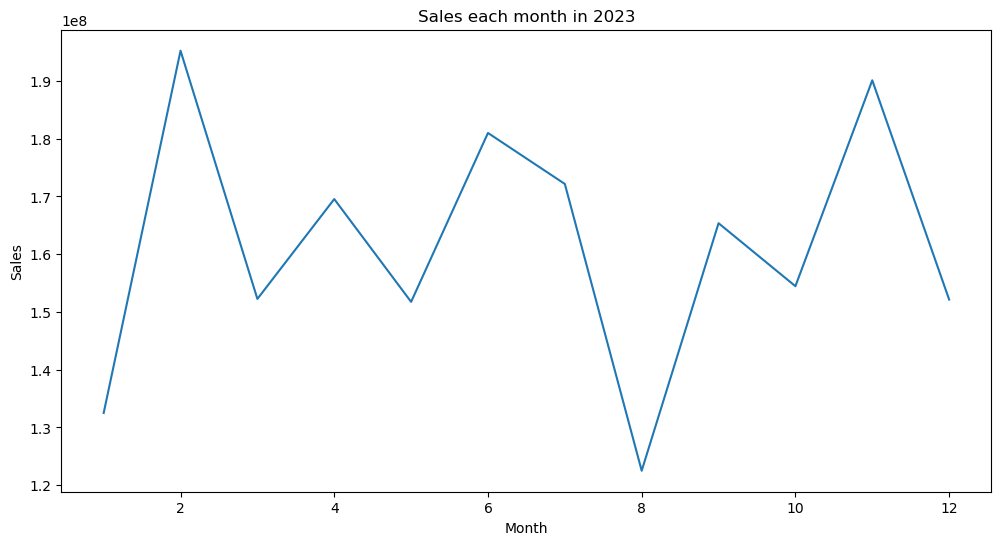

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
data = {'Month': [1, 2,3,4,5,6,7,8,9,10,11,12],
              'Sales': [1.325141e+08, 1.952215e+08, 1.522550e+08, 1.695416e+08, 1.517466e+08, 
                        1.809858e+08, 1.721561e+08, 1.225139e+08, 1.653634e+08, 1.544576e+08,
                         1.901022e+08, 1.521484e+08]}
df = pd.DataFrame(data)
if df.empty:
        print("No data found.")
else:  
    plt.figure(figsize=(12, 6))    
    plt.plot(df['Month'], df['Sales'])
    plt.xlabel('Month')  
    plt.ylabel('Sales')    
    plt.title('Sales each month in 2023')  
    plt.show()